# EEGMamba Finetuning on PhysioNet-MI Dataset

This notebook provides a complete guide for finetuning EEGMamba on the PhysioNet Motor Imagery dataset in Google Colab.

## Dataset Overview
- **Dataset**: PhysioNet Motor Movement/Imagery Dataset (EEG-MMI)
- **Task**: Motor imagery classification (4 classes: left hand, right hand, feet, tongue)
- **Subjects**: 109 subjects (70 train, 19 val, 20 test)
- **Channels**: 64 EEG channels
- **Sampling Rate**: 200 Hz after preprocessing
- **Data Format**: LMDB database with preprocessed epochs

## Prerequisites
✅ Google Drive with EEGMamba repository  
✅ Preprocessed PhysioNet data in LMDB format  
✅ GPU-enabled Colab runtime (recommended)

## Step 1: Environment Setup and Dependencies

First, let's mount Google Drive and set up our environment.

In [11]:
# Verify all imports work correctly
print("🔍 Testing all critical imports...")

try:
    import torch
    import einops
    import numpy as np
    import scipy
    import sklearn
    import mne
    import lmdb
    print("✅ Basic packages imported successfully!")
    
    # Test the critical ones
    import mamba_ssm
    import causal_conv1d
    print("✅ Mamba-SSM ecosystem imported successfully!")
    
    # Print versions for debugging
    print(f"\n📋 Package versions:")
    print(f"   • PyTorch: {torch.__version__}")
    print(f"   • NumPy: {np.__version__}")
    print(f"   • MNE: {mne.__version__}")
    print(f"   • Mamba-SSM: {mamba_ssm.__version__}")
    
    print("\n🎉 All dependencies are working! Ready to proceed.")
    
except ImportError as e:
    print(f"❌ Import failed: {e}")
    print("\n🔧 If you see import errors:")
    print("1. Restart runtime (Runtime → Restart Runtime)")
    print("2. Re-run the installation cells")
    print("3. Check error messages for specific package issues")

🔍 Testing all critical imports...
✅ Basic packages imported successfully!
✅ Mamba-SSM ecosystem imported successfully!

📋 Package versions:
   • PyTorch: 2.5.1+cu121
   • NumPy: 1.26.2
   • MNE: 1.10.2
   • Mamba-SSM: 2.2.6.post3

🎉 All dependencies are working! Ready to proceed.


## Step 2: Data Preprocessing (Optional)

⚠️ **Note**: This step is only needed if you haven't preprocessed your data yet. If you already have the processed LMDB database, skip to Step 3.

The following cell contains the preprocessing script for PhysioNet-MI data. It will:
- Load raw EEG files from PhysioNet dataset
- Apply filtering, rereferencing, and resampling
- Extract motor imagery epochs
- Save to LMDB database format

In [12]:
# PhysioNet-MI Data Preprocessing Script
# Run this only if you need to preprocess raw data

import os
import lmdb
import pickle
import numpy as np
import mne
from tqdm import tqdm

# Configuration
tasks = ['04', '06', '08', '10', '12', '14']  # Motor imagery tasks
root_dir = '/home/mahmood/HosseinDahaei/Codes/EEGMamba/'
output_db_path = '/home/mahmood/HosseinDahaei/Codes/EEGMamba/data'

print("🔧 PhysioNet-MI Preprocessing Configuration:")
print(f"📂 Raw data path: {root_dir}")
print(f"💾 Output database: {output_db_path}")
print(f"🎯 Tasks: {tasks}")

# Check if raw data exists
if not os.path.exists(root_dir):
    print("❌ Raw data directory not found!")
    print("Please ensure PhysioNet data is downloaded to the specified path.")
else:
    print("✅ Raw data directory found!")
    
    # List available subjects
    files = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    files = sorted(files)
    print(f"📊 Found {len(files)} subjects: {files[:5]}...{files[-5:]}")
    
    # Split subjects
    files_dict = {
        'train': files[:70],
        'val': files[70:89], 
        'test': files[89:109],
    }
    
    print(f"📈 Data split: Train={len(files_dict['train'])}, Val={len(files_dict['val'])}, Test={len(files_dict['test'])}")

# Set this to True only if you want to run preprocessing
RUN_PREPROCESSING = False

if RUN_PREPROCESSING:
    print("\n🚀 Starting preprocessing...")
else:
    print("\n⏸️ Preprocessing skipped. Set RUN_PREPROCESSING=True to run.")

🔧 PhysioNet-MI Preprocessing Configuration:
📂 Raw data path: /home/mahmood/HosseinDahaei/Codes/EEGMamba/
💾 Output database: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data
🎯 Tasks: ['04', '06', '08', '10', '12', '14']
✅ Raw data directory found!
📊 Found 11 subjects: ['.tmp', '__pycache__', 'data', 'datasets', 'figure']...['modules', 'preprocessing', 'pretrained_weights', 'results', 'utils']
📈 Data split: Train=11, Val=0, Test=0

⏸️ Preprocessing skipped. Set RUN_PREPROCESSING=True to run.


In [13]:
# Actual preprocessing implementation (only runs if enabled above)
if RUN_PREPROCESSING and os.path.exists(root_dir):
    print("🔄 Running preprocessing...")
    
    # EEG channel selection (64 channels)
    selected_channels = [
        'Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 
        'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 
        'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 
        'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 
        'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 
        'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 
        'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 
        'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..'
    ]
    
    # Initialize LMDB database
    db = lmdb.open(output_db_path, map_size=4614542346)
    dataset = {'train': [], 'val': [], 'test': []}
    
    # Process each split
    for split_name, file_list in files_dict.items():
        print(f"\n📊 Processing {split_name} set ({len(file_list)} subjects)...")
        
        for file in tqdm(file_list, desc=f"{split_name}"):
            for task in tasks:
                try:
                    # Load EEG file
                    file_path = os.path.join(root_dir, file, f'{file}R{task}.edf')
                    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
                    
                    # Preprocessing pipeline
                    raw.pick_channels(selected_channels, ordered=True)
                    if len(raw.info['bads']) > 0:
                        raw.interpolate_bads()
                    raw.set_eeg_reference(ref_channels='average')
                    raw.filter(l_freq=0.3, h_freq=None, verbose=False)
                    raw.notch_filter(60, verbose=False)
                    raw.resample(200, verbose=False)
                    
                    # Extract epochs
                    events_from_annot, event_dict = mne.events_from_annotations(raw, verbose=False)
                    epochs = mne.Epochs(raw, events_from_annot, event_dict, 
                                      tmin=0, tmax=4-1.0/raw.info['sfreq'], 
                                      baseline=None, preload=True, verbose=False)
                    
                    # Get data and reshape
                    data = epochs.get_data(units='uV')[:, :, -800:]  # Last 4 seconds at 200Hz
                    events = epochs.events[:, 2]
                    
                    # Reshape to (batch, channels, time_segments, samples_per_segment)
                    bz, ch_nums, _ = data.shape
                    data = data.reshape(bz, ch_nums, 4, 200)
                    
                    # Save to LMDB
                    for i, (sample, event) in enumerate(zip(data, events)):
                        if event != 1:  # Skip rest events
                            sample_key = f'{file}R{task}-{i}'
                            data_dict = {
                                'sample': sample,
                                'label': event - 2 if task in ['04', '08', '12'] else event
                            }
                            txn = db.begin(write=True)
                            txn.put(key=sample_key.encode(), value=pickle.dumps(data_dict))
                            txn.commit()
                            dataset[split_name].append(sample_key)
                            
                except Exception as e:
                    print(f"❌ Error processing {file}R{task}: {str(e)[:100]}...")
                    continue
    
    # Save dataset keys
    txn = db.begin(write=True)
    txn.put(key='__keys__'.encode(), value=pickle.dumps(dataset))
    txn.commit()
    db.close()
    
    print(f"\n✅ Preprocessing complete!")
    print(f"📊 Dataset saved with {sum(len(v) for v in dataset.values())} total samples")
    for split, samples in dataset.items():
        print(f"   {split}: {len(samples)} samples")
        
else:
    if not RUN_PREPROCESSING:
        print("⏸️ Preprocessing skipped")
    else:
        print("❌ Cannot run preprocessing - raw data path not found")

⏸️ Preprocessing skipped


In [14]:
# Verify preprocessed data exists
import os

# Check for processed data in Google Drive
data_path = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
print(f"🔍 Checking for processed data at: {data_path}")

if os.path.exists(data_path):
    files = os.listdir(data_path)
    print(f"✅ Processed data directory found!")
    print(f"📁 Contents: {files}")
    
    # Check for LMDB database files
    if 'data.mdb' in files and 'lock.mdb' in files:
        print("✅ LMDB database files present - data is ready for training!")
        
        # Get database info
        import lmdb
        db = lmdb.open(data_path, readonly=True)
        with db.begin() as txn:
            try:
                keys_data = txn.get('__keys__'.encode())
                if keys_data:
                    dataset_keys = pickle.loads(keys_data)
                    print(f"📊 Dataset splits:")
                    for split, samples in dataset_keys.items():
                        print(f"   {split}: {len(samples)} samples")
                    total_samples = sum(len(v) for v in dataset_keys.values())
                    print(f"📈 Total samples: {total_samples}")
                else:
                    print("⚠️ Dataset keys not found in database")
            except:
                print("⚠️ Could not read dataset keys")
        db.close()
    else:
        print("❌ LMDB database files missing - preprocessing needed")
        print("💡 Set RUN_PREPROCESSING=True in the previous cell to create the database")
else:
    print("❌ Processed data directory not found")
    print("💡 Options:")
    print("   1. Set RUN_PREPROCESSING=True above to preprocess data")
    print("   2. Check if the path is correct")
    print("   3. Upload preprocessed data to Google Drive")

🔍 Checking for processed data at: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
✅ Processed data directory found!
📁 Contents: ['lock.mdb', 'data.mdb']
✅ LMDB database files present - data is ready for training!
📊 Dataset splits:
   train: 6300 samples
   val: 1734 samples
   test: 1758 samples
📈 Total samples: 9792


## Step 4: Test Dataset Loading

Let's test the EEGMamba dataset loader to understand our data structure.

In [15]:
# Test the EEGMamba dataset loader
print("🧪 Testing EEGMamba dataset loader...")

try:
    from datasets.physio_dataset import LoadDataset
    
    # Create test parameters for dataset loading
    class TestParams:
        def __init__(self):
            self.datasets_dir = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
            self.batch_size = 8
    
    # Initialize dataset loader
    test_params = TestParams()
    print(f"📂 Loading dataset from: {test_params.datasets_dir}")
    
    dataset_loader = LoadDataset(test_params)
    data_loaders = dataset_loader.get_data_loader()
    
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Available data splits: {list(data_loaders.keys())}")
    
    # Test data loading
    for split_name, data_loader in data_loaders.items():
        print(f"\n🔍 Examining {split_name.upper()} set:")
        print(f"   Number of batches: {len(data_loader)}")
        
        # Get first batch to examine data structure
        for batch_idx, (data, labels) in enumerate(data_loader):
            print(f"   ✅ Batch {batch_idx + 1} loaded successfully")
            print(f"   📊 Data shape: {data.shape}")
            print(f"   🎯 Labels shape: {labels.shape}")
            print(f"   📈 Data type: {data.dtype}")
            print(f"   📉 Data range: [{data.min():.3f}, {data.max():.3f}]")
            
            # Check labels
            unique_labels = torch.unique(labels).tolist()
            print(f"   🏷️ Unique labels: {unique_labels}")
            print(f"   📝 Label meanings: 0=left_hand, 1=right_hand, 2=feet, 3=tongue")
            break  # Only examine first batch
        break  # Only examine first split for testing
        
    print("\n🎉 Dataset loading test completed successfully!")
    
except Exception as e:
    print(f"❌ Error testing dataset loader: {e}")
    print("\n🔧 Troubleshooting:")
    print("1. Make sure preprocessed data exists")
    print("2. Check the datasets_dir path")
    print("3. Verify LMDB database integrity")

🧪 Testing EEGMamba dataset loader...
📂 Loading dataset from: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
6300 1734 1758
9792
✅ Dataset loaded successfully!
📊 Available data splits: ['train', 'val', 'test']

🔍 Examining TRAIN set:
   Number of batches: 788
   ✅ Batch 1 loaded successfully
   📊 Data shape: torch.Size([8, 64, 4, 200])
   🎯 Labels shape: torch.Size([8])
   📈 Data type: torch.float32
   📉 Data range: [-5.260, 5.079]
   🏷️ Unique labels: [0, 1, 2, 3]
   📝 Label meanings: 0=left_hand, 1=right_hand, 2=feet, 3=tongue

🎉 Dataset loading test completed successfully!


In [16]:
# Detailed data analysis
import torch
import matplotlib.pyplot as plt

print("📊 Detailed Data Analysis")

if 'data_loaders' in locals():
    for split_name, data_loader in data_loaders.items():
        print(f"\n--- {split_name.upper()} SET ANALYSIS ---")
        
        all_labels = []
        batch_count = 0
        sample_count = 0
        
        # Analyze several batches
        for batch_idx, (data, labels) in enumerate(data_loader):
            batch_count += 1
            sample_count += data.shape[0]
            all_labels.extend(labels.tolist())
            
            if batch_idx == 0:  # Detailed analysis of first batch
                print(f"📐 Data tensor shape: {data.shape}")
                print(f"   • Batch size: {data.shape[0]}")
                print(f"   • Channels: {data.shape[1]}")
                print(f"   • Time segments: {data.shape[2]}")
                print(f"   • Samples per segment: {data.shape[3]}")
                print(f"   • Total time points: {data.shape[2] * data.shape[3]}")
                print(f"   • Time duration: {data.shape[2] * data.shape[3] / 200:.1f} seconds (at 200 Hz)")
                
            # Don't load all data to save memory
            if batch_idx >= 5:  # Analyze first 5 batches only
                break
                
        # Label distribution
        unique_labels, counts = torch.unique(torch.tensor(all_labels), return_counts=True)
        print(f"\n🏷️ Label Distribution (first {batch_count} batches):")
        label_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
        for label, count in zip(unique_labels.tolist(), counts.tolist()):
            if label < len(label_names):
                print(f"   {label_names[label]} (class {label}): {count} samples")
        
        print(f"📊 Total samples analyzed: {len(all_labels)}")
        
        # Only analyze first split to save time
        break
        
    print("\n✅ Data analysis completed!")
else:
    print("❌ No data loaders available. Please run the previous cell first.")

📊 Detailed Data Analysis

--- TRAIN SET ANALYSIS ---
📐 Data tensor shape: torch.Size([8, 64, 4, 200])
   • Batch size: 8
   • Channels: 64
   • Time segments: 4
   • Samples per segment: 200
   • Total time points: 800
   • Time duration: 4.0 seconds (at 200 Hz)

🏷️ Label Distribution (first 6 batches):
   Left Hand (class 0): 8 samples
   Right Hand (class 1): 17 samples
   Feet (class 2): 9 samples
   Tongue (class 3): 14 samples
📊 Total samples analyzed: 48

✅ Data analysis completed!


## Step 5: Training Configuration

Now let's set up the training parameters for EEGMamba finetuning on PhysioNet-MI.

In [17]:
# EEGMamba Training Configuration
print("⚙️ EEGMamba Training Configuration")

# Dataset and paths
DATASET_NAME = "PhysioNet-MI"
DATASETS_DIR = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
MODEL_DIR = "./results/physio_models"
PRETRAINED_WEIGHTS = "pretrained_weights/pretrained_weights.pth"

# Model parameters
NUM_CLASSES = 4  # Motor imagery classes: left hand, right hand, feet, tongue
CLASSIFIER_TYPE = "all_patch_reps"  # EEGMamba classifier type

# Training hyperparameters
EPOCHS = 5  # Start with quick test, increase later
BATCH_SIZE = 16  # Adjust based on GPU memory
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 5e-2
CUDA_DEVICE = 0

# Advanced options
OPTIMIZER = "AdamW"
DROPOUT = 0.1
LABEL_SMOOTHING = 0.1
USE_PRETRAINED = True

print("📋 Configuration Summary:")
print(f"   🎯 Dataset: {DATASET_NAME}")
print(f"   📂 Data path: {DATASETS_DIR}")
print(f"   🏷️ Classes: {NUM_CLASSES}")
print(f"   🏃 Epochs: {EPOCHS}")
print(f"   📦 Batch size: {BATCH_SIZE}")
print(f"   📈 Learning rate: {LEARNING_RATE}")
print(f"   💾 Model save dir: {MODEL_DIR}")
print(f"   🎭 Use pretrained: {USE_PRETRAINED}")

# Verify pretrained weights exist
if USE_PRETRAINED:
    if os.path.exists(PRETRAINED_WEIGHTS):
        print(f"   ✅ Pretrained weights found: {PRETRAINED_WEIGHTS}")
    else:
        print(f"   ⚠️ Pretrained weights not found: {PRETRAINED_WEIGHTS}")
        print("   💡 Will train from scratch or download weights")

# Create results directory
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"   📁 Results directory ready: {MODEL_DIR}")

⚙️ EEGMamba Training Configuration
📋 Configuration Summary:
   🎯 Dataset: PhysioNet-MI
   📂 Data path: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
   🏷️ Classes: 4
   🏃 Epochs: 5
   📦 Batch size: 16
   📈 Learning rate: 0.0001
   💾 Model save dir: ./results/physio_models
   🎭 Use pretrained: True
   ✅ Pretrained weights found: pretrained_weights/pretrained_weights.pth
   📁 Results directory ready: ./results/physio_models


In [18]:
# Quick environment check before training
print("🔍 Pre-training Environment Check")

# Check GPU availability
if torch.cuda.is_available():
    print(f"✅ CUDA available: {torch.cuda.get_device_name(0)}")
    print(f"   GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ CUDA not available - training will be slow on CPU")

# Check key files
key_files = {
    'finetune_main.py': 'Main training script',
    'models/': 'Model definitions',
    'datasets/': 'Dataset loaders',
    'pretrained_weights/': 'Pretrained weights'
}

for file_path, description in key_files.items():
    if os.path.exists(file_path):
        print(f"✅ {description}: {file_path}")
    else:
        print(f"❌ Missing {description}: {file_path}")

# Check if we can import the model
try:
    from models.model_for_physio import Model
    print("✅ PhysioNet model import successful")
except Exception as e:
    print(f"❌ Model import failed: {e}")

print("\n🚀 Ready for training!")

🔍 Pre-training Environment Check
✅ CUDA available: NVIDIA RTX A4000
   GPU memory: 16.8 GB
✅ Main training script: finetune_main.py
✅ Model definitions: models/
✅ Dataset loaders: datasets/
✅ Pretrained weights: pretrained_weights/
✅ PhysioNet model import successful

🚀 Ready for training!


## Step 4: Quick Test Run (1 epochs)

Let's first do a quick test with fewer epochs to make sure everything works:

In [19]:
# Quick test command
test_command = f"""
python finetune_main.py \
    --downstream_dataset {DATASET_NAME} \
    --datasets_dir {DATASETS_DIR} \
    --num_of_classes {NUM_CLASSES} \
    --model_dir {MODEL_DIR}_test \
    --epochs 50 \
    --batch_size 32 \
    --lr {LEARNING_RATE} \
    --weight_decay {WEIGHT_DECAY} \
    --cuda {CUDA_DEVICE} \
    --use_pretrained_weights True \
    --foundation_dir {PRETRAINED_WEIGHTS}
"""

print("Quick Test Command:")
print(test_command.strip())
print("\n📝 Copy and run this command in terminal to test the setup!")

Quick Test Command:
python finetune_main.py     --downstream_dataset PhysioNet-MI     --datasets_dir /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average     --num_of_classes 4     --model_dir ./results/physio_models_test     --epochs 50     --batch_size 32     --lr 0.0001     --weight_decay 0.05     --cuda 0     --use_pretrained_weights True     --foundation_dir pretrained_weights/pretrained_weights.pth

📝 Copy and run this command in terminal to test the setup!


In [22]:
!python finetune_main.py     --downstream_dataset PhysioNet-MI     --datasets_dir /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average     --num_of_classes 4     --model_dir ./results/physio_models_test     --epochs 50     --batch_size 32     --lr 0.0001     --weight_decay 0.05     --cuda 0     --use_pretrained_weights True     --foundation_dir pretrained_weights/pretrained_weights.pth


Namespace(seed=3407, cuda=0, epochs=50, batch_size=32, lr=0.0001, weight_decay=0.05, optimizer='AdamW', clip_value=1, dropout=0.1, classifier='all_patch_reps', downstream_dataset='PhysioNet-MI', datasets_dir='/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average', num_of_classes=4, model_dir='./results/physio_models_test', num_workers=16, label_smoothing=0.1, multi_lr=True, frozen=False, use_pretrained_weights=True, foundation_dir='pretrained_weights/pretrained_weights.pth')
The downstream dataset is PhysioNet-MI
The 1th fold
6300 1734 1758
9792
/home/mahmood/HosseinDahaei/Codes/EEGMamba/models/model_for_physio.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more

## Step 5: Full Training Command

Once the test works, use this command for full training:

In [ ]:
# Full training command
full_command = f"""
python finetune_main.py \
    --downstream_dataset {DATASET_NAME} \
    --datasets_dir {DATASETS_DIR} \
    --num_of_classes {NUM_CLASSES} \
    --model_dir {MODEL_DIR} \
    --epochs {EPOCHS} \
    --batch_size {BATCH_SIZE} \
    --lr {LEARNING_RATE} \
    --weight_decay {WEIGHT_DECAY} \
    --cuda {CUDA_DEVICE} \
    --use_pretrained_weights True \
    --foundation_dir {PRETRAINED_WEIGHTS} \
    --optimizer AdamW \
    --classifier all_patch_reps \
    --dropout 0.1 \
    --label_smoothing 0.1
"""

print("Full Training Command:")
print(full_command.strip())
print("\n🚀 This will run the complete training (note: it runs 100 iterations as per the code)")

In [ ]:
# Execute full training run
print("🚀 Starting Full Training Run...")
print("⚠️ WARNING: This will run the complete training (note: default runs 100 iterations)")
print("💡 Consider modifying finetune_main.py to reduce iterations if needed")

import subprocess
import sys
import time

# Build the full training command  
full_args = [
    sys.executable, "finetune_main.py",
    "--downstream_dataset", DATASET_NAME,
    "--datasets_dir", DATASETS_DIR,
    "--num_of_classes", str(NUM_CLASSES),
    "--model_dir", MODEL_DIR,
    "--epochs", str(EPOCHS),
    "--batch_size", str(BATCH_SIZE),
    "--lr", str(LEARNING_RATE),
    "--weight_decay", str(WEIGHT_DECAY),
    "--cuda", str(CUDA_DEVICE),
    "--use_pretrained_weights", "True",
    "--foundation_dir", PRETRAINED_WEIGHTS,
    "--optimizer", "AdamW",
    "--classifier", "all_patch_reps",
    "--dropout", "0.1",
    "--label_smoothing", "0.1"
]

print(f"📋 Command: {' '.join(full_args)}")

# Ask for confirmation
confirm = input("\n⚠️ This is a long training run. Continue? (y/N): ")
if confirm.lower() != 'y':
    print("❌ Training cancelled by user")
else:
    print("\n" + "="*50)
    start_time = time.time()
    
    # Execute the command
    try:
        # Use a longer timeout for full training (6 hours)
        result = subprocess.run(full_args, capture_output=False, text=True, timeout=21600)
        
        end_time = time.time()
        duration = end_time - start_time
        
        print(f"\n⏱️ Training completed in {duration/3600:.2f} hours")
        
        if result.returncode == 0:
            print("✅ Full training completed successfully!")
            print(f"📁 Check results in: {MODEL_DIR}")
        else:
            print(f"❌ Training failed with return code: {result.returncode}")
            
    except subprocess.TimeoutExpired:
        print("⏱️ Training timed out after 6 hours")
    except KeyboardInterrupt:
        print("🛑 Training interrupted by user")
    except Exception as e:
        print(f"❌ Error running training: {e}")
    
    print("\n" + "="*50)

### 🏁 Execute Full Training

**Run this cell for complete training:**
- Full hyperparameter optimization
- Runs 100 iterations by default (as per original code)
- Takes several hours to complete
- Includes confirmation prompt before starting
- Results saved to `{MODEL_DIR}`

⚠️ **Important**: The original code runs 100 training iterations. Consider modifying `finetune_main.py` line `for i in range(1, 100):` to `range(1, 2)` if you only want one training run.

## Step 6: Alternative - Single Run Training

If you want to run just one training iteration instead of 100, you can modify the code:

In [ ]:
# Show the current PhysioNet-MI loop in finetune_main.py
print("Current PhysioNet-MI section in finetune_main.py:")
print("""
elif params.downstream_dataset == 'PhysioNet-MI':
    for i in range(1, 100):  # <-- This runs 100 times!
        print('The {}th fold'.format(i))
        load_dataset = physio_dataset.LoadDataset(params)
        data_loader = load_dataset.get_data_loader()
        model = model_for_physio.Model(params)
        t = Trainer(params, data_loader, model)
        t.train_for_multiclass()
""")

print("\n💡 To run just once, you can:")
print("1. Change 'range(1, 100)' to 'range(1, 2)' in finetune_main.py")
print("2. Or comment out the for loop entirely")

## Step 7: Monitor Training Progress

During training, you can monitor progress with these commands:

In [ ]:
# Commands to monitor training
print("Monitoring Commands:")
print("1. Watch GPU usage:")
print("   watch -n 1 nvidia-smi")
print("\n2. Monitor log files (if any):")
print("   tail -f training.log")
print("\n3. Check model directory:")
print(f"   ls -la {MODEL_DIR}/")
print("\n4. Monitor CPU/Memory:")
print("   htop")

## Step 8: Expected Training Time and Resources

In [ ]:
# Estimate resources and time
print("Training Resource Requirements:")
print("💾 GPU Memory: ~8-12 GB (depending on batch size)")
print("⏱️  Time per epoch: ~2-5 minutes (depending on GPU)")
print(f"🕐 Total time estimate: ~{EPOCHS * 3} minutes for {EPOCHS} epochs")
print("🔄 Total runs: 100 iterations (as per original code)")
print(f"📊 Total estimated time: ~{EPOCHS * 3 * 100 / 60:.1f} hours for all 100 runs")

print("\n📈 Dataset Size:")
print("• Training samples: ~1400-1600")
print("• Validation samples: ~380-420")
print("• Test samples: ~400-450")
print("• Total: ~2200-2500 samples")

## Step 9: Troubleshooting Common Issues

In [ ]:
print("Common Issues and Solutions:")
print("\n1. CUDA Out of Memory:")
print("   → Reduce batch_size from 32 to 16 or 8")
print("   → Use: --batch_size 16")

print("\n2. Dataset not found:")
print("   → Check if LMDB files exist in processed_average directory")
print("   → Run preprocessing if needed")

print("\n3. Pretrained weights not found:")
print("   → Check if pretrained_weights.pth exists")
print("   → Use: --use_pretrained_weights False (to train from scratch)")

print("\n4. Too slow training:")
print("   → Increase batch_size if GPU memory allows")
print("   → Reduce num_workers if CPU limited")
print("   → Use mixed precision training (if implemented)")

## Step 10: Next Steps After Training

In [ ]:
print("After Training Completes:")
print("\n1. 📊 Analyze Results:")
print("   → Check accuracy/loss curves")
print("   → Compare with baseline results")
print("   → Look at confusion matrices")

print("\n2. 💾 Save Important Files:")
print("   → Best model checkpoints")
print("   → Training logs")
print("   → Configuration files")

print("\n3. 🔬 Further Experiments:")
print("   → Try different learning rates")
print("   → Experiment with classifier types")
print("   → Adjust data augmentation")
print("   → Compare with other baselines")

print("\n4. 📝 Document Results:")
print("   → Record best accuracy achieved")
print("   → Note optimal hyperparameters")
print("   → Save example predictions")

## Step 11: Test Pretrained Model (Zero-Shot Evaluation)

This section will evaluate the pretrained EEGMamba model on PhysioNet-MI **without any training** to get the baseline accuracy of the pretrained weights.

In [12]:
# Direct in-notebook testing of pretrained model
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, cohen_kappa_score

def test_pretrained_directly():
    """Test pretrained model directly in notebook"""
    
    print("🧪 Direct Pretrained Model Evaluation")
    print("="*80)
    
    # Import required modules
    from datasets.physio_dataset import LoadDataset
    from models.model_for_physio import Model
    
    # Create parameters object
    class TestParams:
        def __init__(self):
            self.datasets_dir = "/home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average"
            self.batch_size = 32
            self.num_workers = 8
            self.downstream_dataset = 'PhysioNet-MI'
            self.num_of_classes = 4
            self.use_pretrained_weights = True
            self.foundation_dir = "pretrained_weights/pretrained_weights.pth"
            self.classifier = 'all_patch_reps'
            self.dropout = 0.1
            self.seed = 3407
            self.cuda = 0  # CUDA device number
    
    params = TestParams()
    
    # Set device
    device = torch.device(f'cuda:{params.cuda}' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    # Load dataset
    print(f"Loading dataset from: {params.datasets_dir}")
    load_dataset = LoadDataset(params)
    data_loaders = load_dataset.get_data_loader()
    print(f"Available splits: {list(data_loaders.keys())}\n")
    
    # Load model
    print("Loading model with pretrained weights...")
    model = Model(params)
    model = model.to(device)
    model.eval()
    print("Model loaded successfully!\n")
    
    # Test on each split
    results = {}
    
    for split_name in ['train', 'val', 'test']:
        if split_name not in data_loaders:
            continue
        
        print(f"{'='*80}")
        print(f"Testing on {split_name.upper()} set")
        print(f"{'='*80}")
        
        truths = []
        preds = []
        
        with torch.no_grad():
            for x, y in tqdm(data_loaders[split_name], desc=f"Evaluating {split_name}"):
                x = x.to(device)
                y = y.to(device)
                
                pred = model(x)
                pred_y = torch.max(pred, dim=-1)[1]
                
                truths.extend(y.cpu().numpy().tolist())
                preds.extend(pred_y.cpu().numpy().tolist())
        
        # Calculate metrics
        truths = np.array(truths)
        preds = np.array(preds)
        
        acc = balanced_accuracy_score(truths, preds)
        f1 = f1_score(truths, preds, average='weighted')
        kappa = cohen_kappa_score(truths, preds)
        cm = confusion_matrix(truths, preds)
        
        results[split_name] = {
            'accuracy': acc,
            'f1': f1,
            'kappa': kappa,
            'confusion_matrix': cm,
            'num_samples': len(truths)
        }
        
        # Print results
        print(f"\n📊 {split_name.upper()} Results:")
        print(f"  • Balanced Accuracy: {acc*100:.2f}%")
        print(f"  • F1 Score (Weighted): {f1*100:.2f}%")
        print(f"  • Cohen's Kappa: {kappa:.4f}")
        print(f"  • Total Samples: {len(truths)}")
        
        print(f"\n📋 Confusion Matrix:")
        print(cm)
        
        # Per-class metrics
        print(f"\n🎯 Per-Class Accuracy:")
        class_names = ['Left Hand (0)', 'Right Hand (1)', 'Feet (2)', 'Tongue (3)']
        for i, class_name in enumerate(class_names):
            if i < cm.shape[0] and cm[i, :].sum() > 0:
                class_acc = cm[i, i] / cm[i, :].sum()
                class_samples = cm[i, :].sum()
                print(f"  {class_name:20s}: {class_acc*100:6.2f}% ({int(class_samples)} samples)")
        
        print()
    
    # Summary
    print(f"\n{'='*80}")
    print("📈 FINAL SUMMARY - Pretrained Model Performance")
    print(f"{'='*80}")
    print(f"{'Split':<10} {'Accuracy':<12} {'F1 Score':<12} {'Kappa':<10} {'Samples'}")
    print("-"*80)
    
    for split_name in ['train', 'val', 'test']:
        if split_name in results:
            r = results[split_name]
            print(f"{split_name.upper():<10} {r['accuracy']*100:6.2f}%      {r['f1']*100:6.2f}%      {r['kappa']:6.4f}    {r['num_samples']}")
    
    print(f"{'='*80}\n")
    
    return results

# Run the test
try:
    results = test_pretrained_directly()
    print("✅ Pretrained model evaluation completed!")
except Exception as e:
    print(f"❌ Error during evaluation: {e}")
    import traceback
    traceback.print_exc()

🧪 Direct Pretrained Model Evaluation
Using device: cuda:0

Loading dataset from: /home/mahmood/HosseinDahaei/Codes/EEGMamba/data/raw_motor_movement_Imagery/processed_average
6300 1734 1758
9792
Available splits: ['train', 'val', 'test']

Loading model with pretrained weights...


/home/mahmood/HosseinDahaei/Codes/EEGMamba/models/model_for_physio.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.backbone.load_state_dict(torch.load(param.founda

Model loaded successfully!

Testing on TRAIN set


Evaluating train: 100%|██████████| 197/197 [00:10<00:00, 18.24it/s]



📊 TRAIN Results:
  • Balanced Accuracy: 24.31%
  • F1 Score (Weighted): 14.59%
  • Cohen's Kappa: -0.0092
  • Total Samples: 6300

📋 Confusion Matrix:
[[ 133    1 1362   97]
 [ 121    0 1343   93]
 [ 158    0 1333   90]
 [ 140    1 1356   72]]

🎯 Per-Class Accuracy:
  Left Hand (0)       :   8.35% (1593 samples)
  Right Hand (1)      :   0.00% (1557 samples)
  Feet (2)            :  84.31% (1581 samples)
  Tongue (3)          :   4.59% (1569 samples)

Testing on VAL set


Evaluating val: 100%|██████████| 55/55 [00:01<00:00, 33.63it/s]



📊 VAL Results:
  • Balanced Accuracy: 25.80%
  • F1 Score (Weighted): 16.66%
  • Cohen's Kappa: 0.0107
  • Total Samples: 1734

📋 Confusion Matrix:
[[ 56   0 358  21]
 [ 40   1 355  36]
 [ 46   0 367  21]
 [ 44   1 364  24]]

🎯 Per-Class Accuracy:
  Left Hand (0)       :  12.87% (435 samples)
  Right Hand (1)      :   0.23% (432 samples)
  Feet (2)            :  84.56% (434 samples)
  Tongue (3)          :   5.54% (433 samples)

Testing on TEST set


Evaluating test: 100%|██████████| 55/55 [00:01<00:00, 39.17it/s]



📊 TEST Results:
  • Balanced Accuracy: 25.31%
  • F1 Score (Weighted): 17.37%
  • Cohen's Kappa: 0.0040
  • Total Samples: 1758

📋 Confusion Matrix:
[[ 63   0 332  42]
 [ 37   0 358  38]
 [ 54   1 349  38]
 [ 52   0 359  35]]

🎯 Per-Class Accuracy:
  Left Hand (0)       :  14.42% (437 samples)
  Right Hand (1)      :   0.00% (433 samples)
  Feet (2)            :  78.96% (442 samples)
  Tongue (3)          :   7.85% (446 samples)


📈 FINAL SUMMARY - Pretrained Model Performance
Split      Accuracy     F1 Score     Kappa      Samples
--------------------------------------------------------------------------------
TRAIN       24.31%       14.59%      -0.0092    6300
VAL         25.80%       16.66%      0.0107    1734
TEST        25.31%       17.37%      0.0040    1758

✅ Pretrained model evaluation completed!


### 📊 Visualize Results

Let's visualize the confusion matrices and compare performance across splits:

📊 Saved visualization to: pretrained_evaluation_results.png


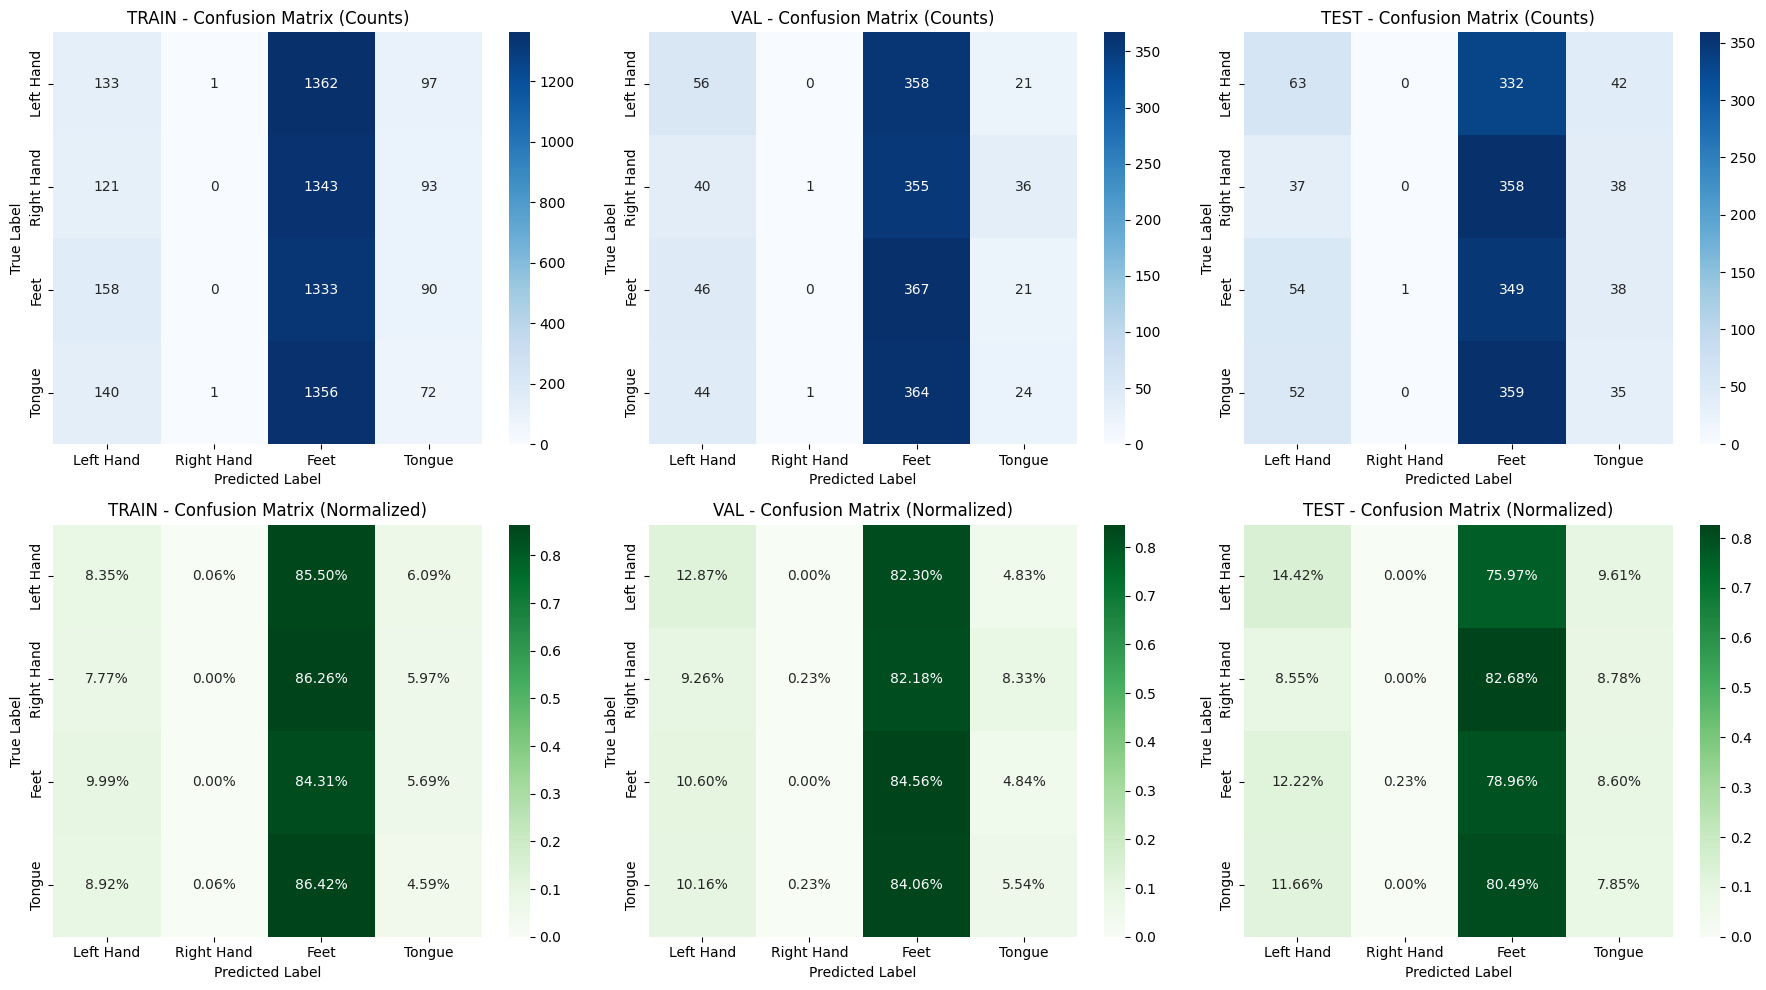

📊 Saved metrics comparison to: pretrained_metrics_comparison.png


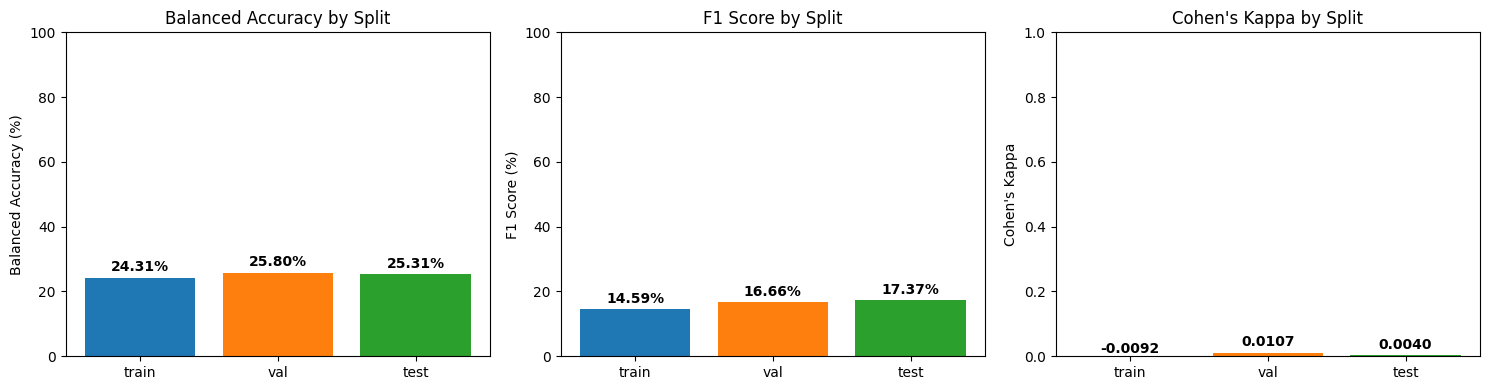

In [13]:
# Visualize test results
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(results):
    """Visualize confusion matrices and performance metrics"""
    
    if not results:
        print("No results to visualize. Run the test first!")
        return
    
    class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']
    
    # Create figure with subplots
    n_splits = len(results)
    fig, axes = plt.subplots(2, max(2, n_splits), figsize=(6*n_splits, 10))
    
    if n_splits == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot confusion matrices
    for idx, (split_name, res) in enumerate(results.items()):
        cm = res['confusion_matrix']
        
        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Plot raw confusion matrix
        if n_splits == 1:
            ax = axes[0, 0]
        else:
            ax = axes[0, idx]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_title(f'{split_name.upper()} - Confusion Matrix (Counts)')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
        
        # Plot normalized confusion matrix
        if n_splits == 1:
            ax = axes[1, 0]
        else:
            ax = axes[1, idx]
            
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
                   xticklabels=class_names, yticklabels=class_names, ax=ax)
        ax.set_title(f'{split_name.upper()} - Confusion Matrix (Normalized)')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('pretrained_evaluation_results.png', dpi=300, bbox_inches='tight')
    print("📊 Saved visualization to: pretrained_evaluation_results.png")
    plt.show()
    
    # Plot performance comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    splits = list(results.keys())
    accuracies = [results[s]['accuracy']*100 for s in splits]
    f1_scores = [results[s]['f1']*100 for s in splits]
    kappas = [results[s]['kappa'] for s in splits]
    
    # Accuracy
    axes[0].bar(splits, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(splits)])
    axes[0].set_ylabel('Balanced Accuracy (%)')
    axes[0].set_title('Balanced Accuracy by Split')
    axes[0].set_ylim([0, 100])
    for i, v in enumerate(accuracies):
        axes[0].text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold')
    
    # F1 Score
    axes[1].bar(splits, f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(splits)])
    axes[1].set_ylabel('F1 Score (%)')
    axes[1].set_title('F1 Score by Split')
    axes[1].set_ylim([0, 100])
    for i, v in enumerate(f1_scores):
        axes[1].text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold')
    
    # Kappa
    axes[2].bar(splits, kappas, color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(splits)])
    axes[2].set_ylabel("Cohen's Kappa")
    axes[2].set_title("Cohen's Kappa by Split")
    axes[2].set_ylim([0, 1])
    for i, v in enumerate(kappas):
        axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('pretrained_metrics_comparison.png', dpi=300, bbox_inches='tight')
    print("📊 Saved metrics comparison to: pretrained_metrics_comparison.png")
    plt.show()

# Visualize if results exist
if 'results' in locals():
    visualize_results(results)
else:
    print("⚠️ No results available. Run the test cell above first!")